# Manifold Parzen Windows

This notebook implements Manifold Parzen Windows from [1]. We use the same dataset as that in the paper for training and evaulation.

[1] Vincent, Pascal, and Yoshua Bengio. "Manifold parzen windows." Advances in neural information processing systems. 2003.

In [1]:
%matplotlib notebook
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def ANLL(densities):
    # helper function to compute average negative log likelihood
    return -np.mean(np.log(densities[densities != 0]))

In [3]:
def plot_2d_density(X, Densities, extent, title=""):
    """
    :param X: training points
    :param Densities: Densities over the grid
    :param extent: grid extents
    :param title: title for the plot
    """
    plt.figure(figsize=(10, 8))
    point_size = .5
    full_title = "Manifold Density Estimation: " + title
    plt.title(full_title)

    plt.imshow(Densities, extent=extent, origin='lower')
    plt.colorbar()
    
    plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.viridis, s=point_size)
    plt.axes().set_aspect('equal', 'datalim')
    
    plt.show()

In [4]:
def LocalGaussian(x, x_i, V_i, lambda_i, d, sig2):
    """
    :param x: numpy 1-d array, test vector of shape (n, )
    :param x_i: numpy 1-d array, training vector of shape (n, )
    :param V_i: numpy ndarray, d eigenvectors corresponding to ith training point of shape (n, d)
    :param lambda_i: numpy 1-d array, d eigenvalues corresponding to the ith training point of shape (d, )
    :param d: int, number of principal directions
    :param sig2: float, regularization hyperparameter
    :returns G: Gaussian density
    """
    n = x.shape[0]
    r = d * np.log(2 * np.pi) + np.sum(np.log(lambda_i)) + (n - d) * np.log(sig2) 
    # above line has fixed a suspected typo in original paper which added \sigma^2 to lambda_i again here
    q = (1.0 / sig2) * np.sum(np.square(x - x_i))
    for j in range(d):
        temp = ((1.0 / lambda_i[j]) - (1.0 / sig2)) * np.square(np.dot(V_i[:, j], (x - x_i)))
        q = q + temp
    return np.exp(-0.5 * (r + q))

In [5]:
def ManifoldParzenTrain(X, d, k, sig2):
    """
    :param X: numpy ndarray, training set of shape (l, n)
    :param d: int, number of principal directions
    :param k: int, chosen number of neighbors
    :param sig2: float, regularization hyperparameter
    :returns Model: dict, contains (X, V, lambdaVec, k, d, sig2) where V is an (l, n, d) tensor that
    collects all the eigenvectors and lambdaVec is a (l, d) matrix with all the eigenvalues
    """
    l, n = X.shape
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', leaf_size=30).fit(X)
    V = np.zeros((l, n, d))
    lambdaVec = np.zeros((l, d))

    [dists, idx] = nbrs.kneighbors(X)

    for i in xrange(l):
        ids = idx[i]
        M = np.zeros((k, n))
        for j in range(ids.shape[0]):
            M[j, :] = X[ids[j]] - X[i]

        Ui, s, Vi = np.linalg.svd(M, full_matrices=False)

        s_d = s[0:d]
        V_d = Vi[0:d, :].T

        V[i, :, :] = V_d
        lambdaVec[i, :] = (np.square(s_d) / l) + sig2

    Model = {"tr_set": X, "eigenVec": V, "lambda": lambdaVec, "nbrs": k, "dim": d, "var": sig2}
    return Model

In [6]:
def ManifoldParzenTest(x, M):
    """
    :param x: numpy 1-d array, test vector of shape (n, )
    :param M: dict, the Model comprising of (X, V, lambdaVec, k, d, sig2)
    :returns phat: estimated density function evaluated at test point x
    """
    phat = 0
    X, V, lambdaVec, k, d, sig2 = M["tr_set"], M["eigenVec"], M["lambda"], M["nbrs"], M["dim"], M["var"]
    l, n = X.shape
    for i in xrange(l):
        phat = phat + LocalGaussian(x, X[i], V[i], lambdaVec[i], d, sig2)
    return phat / l

## Tests

### Generate data over the 2D grid

In [7]:
NUM_TRAINING = 300
NUM_TESTING = 10000

# training data
t = np.random.uniform(3, 15, NUM_TRAINING)

X = np.zeros((NUM_TRAINING, 2))
X[:, 0] = 0.04 * t * np.sin(t) + np.random.normal(0, 0.01, NUM_TRAINING)
X[:, 1] = 0.04 * t * np.cos(t) + np.random.normal(0, 0.01, NUM_TRAINING)

# test data
t_te = np.random.uniform(3, 15, NUM_TESTING)

X_te = np.zeros((NUM_TESTING, 2))
X_te[:, 0] = 0.04 * t_te * np.sin(t_te) + np.random.normal(0, 0.01, NUM_TESTING)
X_te[:, 1] = 0.04 * t_te * np.cos(t_te) + np.random.normal(0, 0.01, NUM_TESTING)

### Build the MPW model

In [8]:
# set parameters as in [1]
manifold_dimensions = 1 # d
num_neighbors = 11 # k
noise = np.square(0.09) # sig2

model = ManifoldParzenTrain(X, manifold_dimensions, num_neighbors, noise)

### Evaluate densities on the grid

In [9]:
LEFT = -.8
RIGHT = .8
BOTTOM = -.8
TOP = .8
extent = [LEFT, RIGHT, BOTTOM, TOP]
xs = np.arange(LEFT, RIGHT, 0.01)
ys = np.arange(BOTTOM, TOP, 0.01)
xx, yy = np.meshgrid(xs, ys)

x_flat = xx.flatten()
y_flat = yy.flatten()

background = np.vstack((x_flat, y_flat)).T
background.shape

(25600, 2)

In [10]:
num_background = background.shape[0]
likelihoods = np.zeros((num_background, 1))
for i in range(num_background):
    likelihoods[i] = ManifoldParzenTest(background[i], model)

likelihoods_image = np.reshape(likelihoods, xx.shape)

### Evaluate results visually

<IPython.core.display.Javascript object>


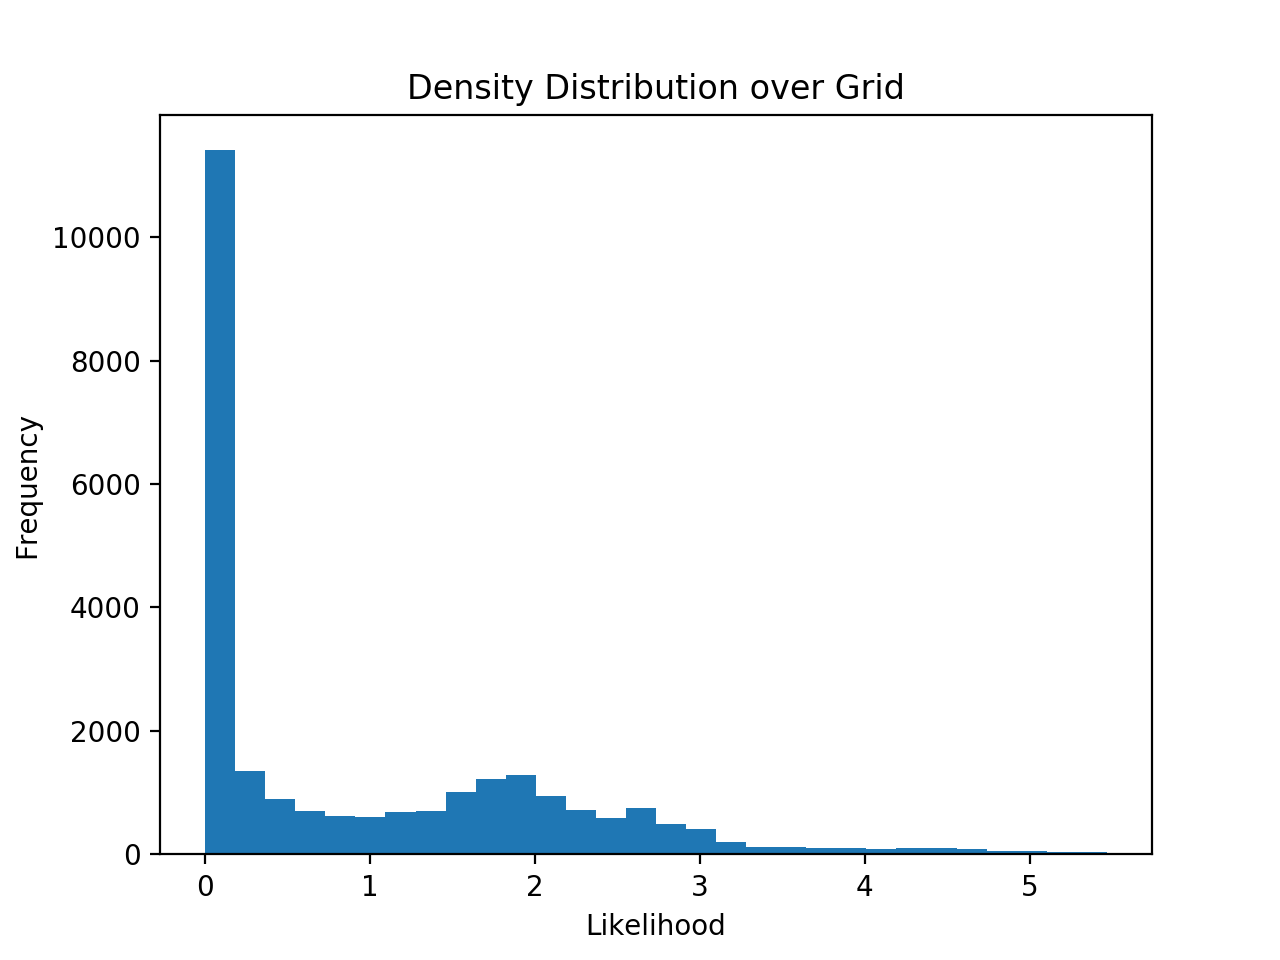

In [11]:
plt.figure()
plt.hist(likelihoods, bins=30)
plt.title('Density Distribution over Grid')
plt.xlabel('Likelihood')
plt.ylabel('Frequency')
plt.show()

<IPython.core.display.Javascript object>


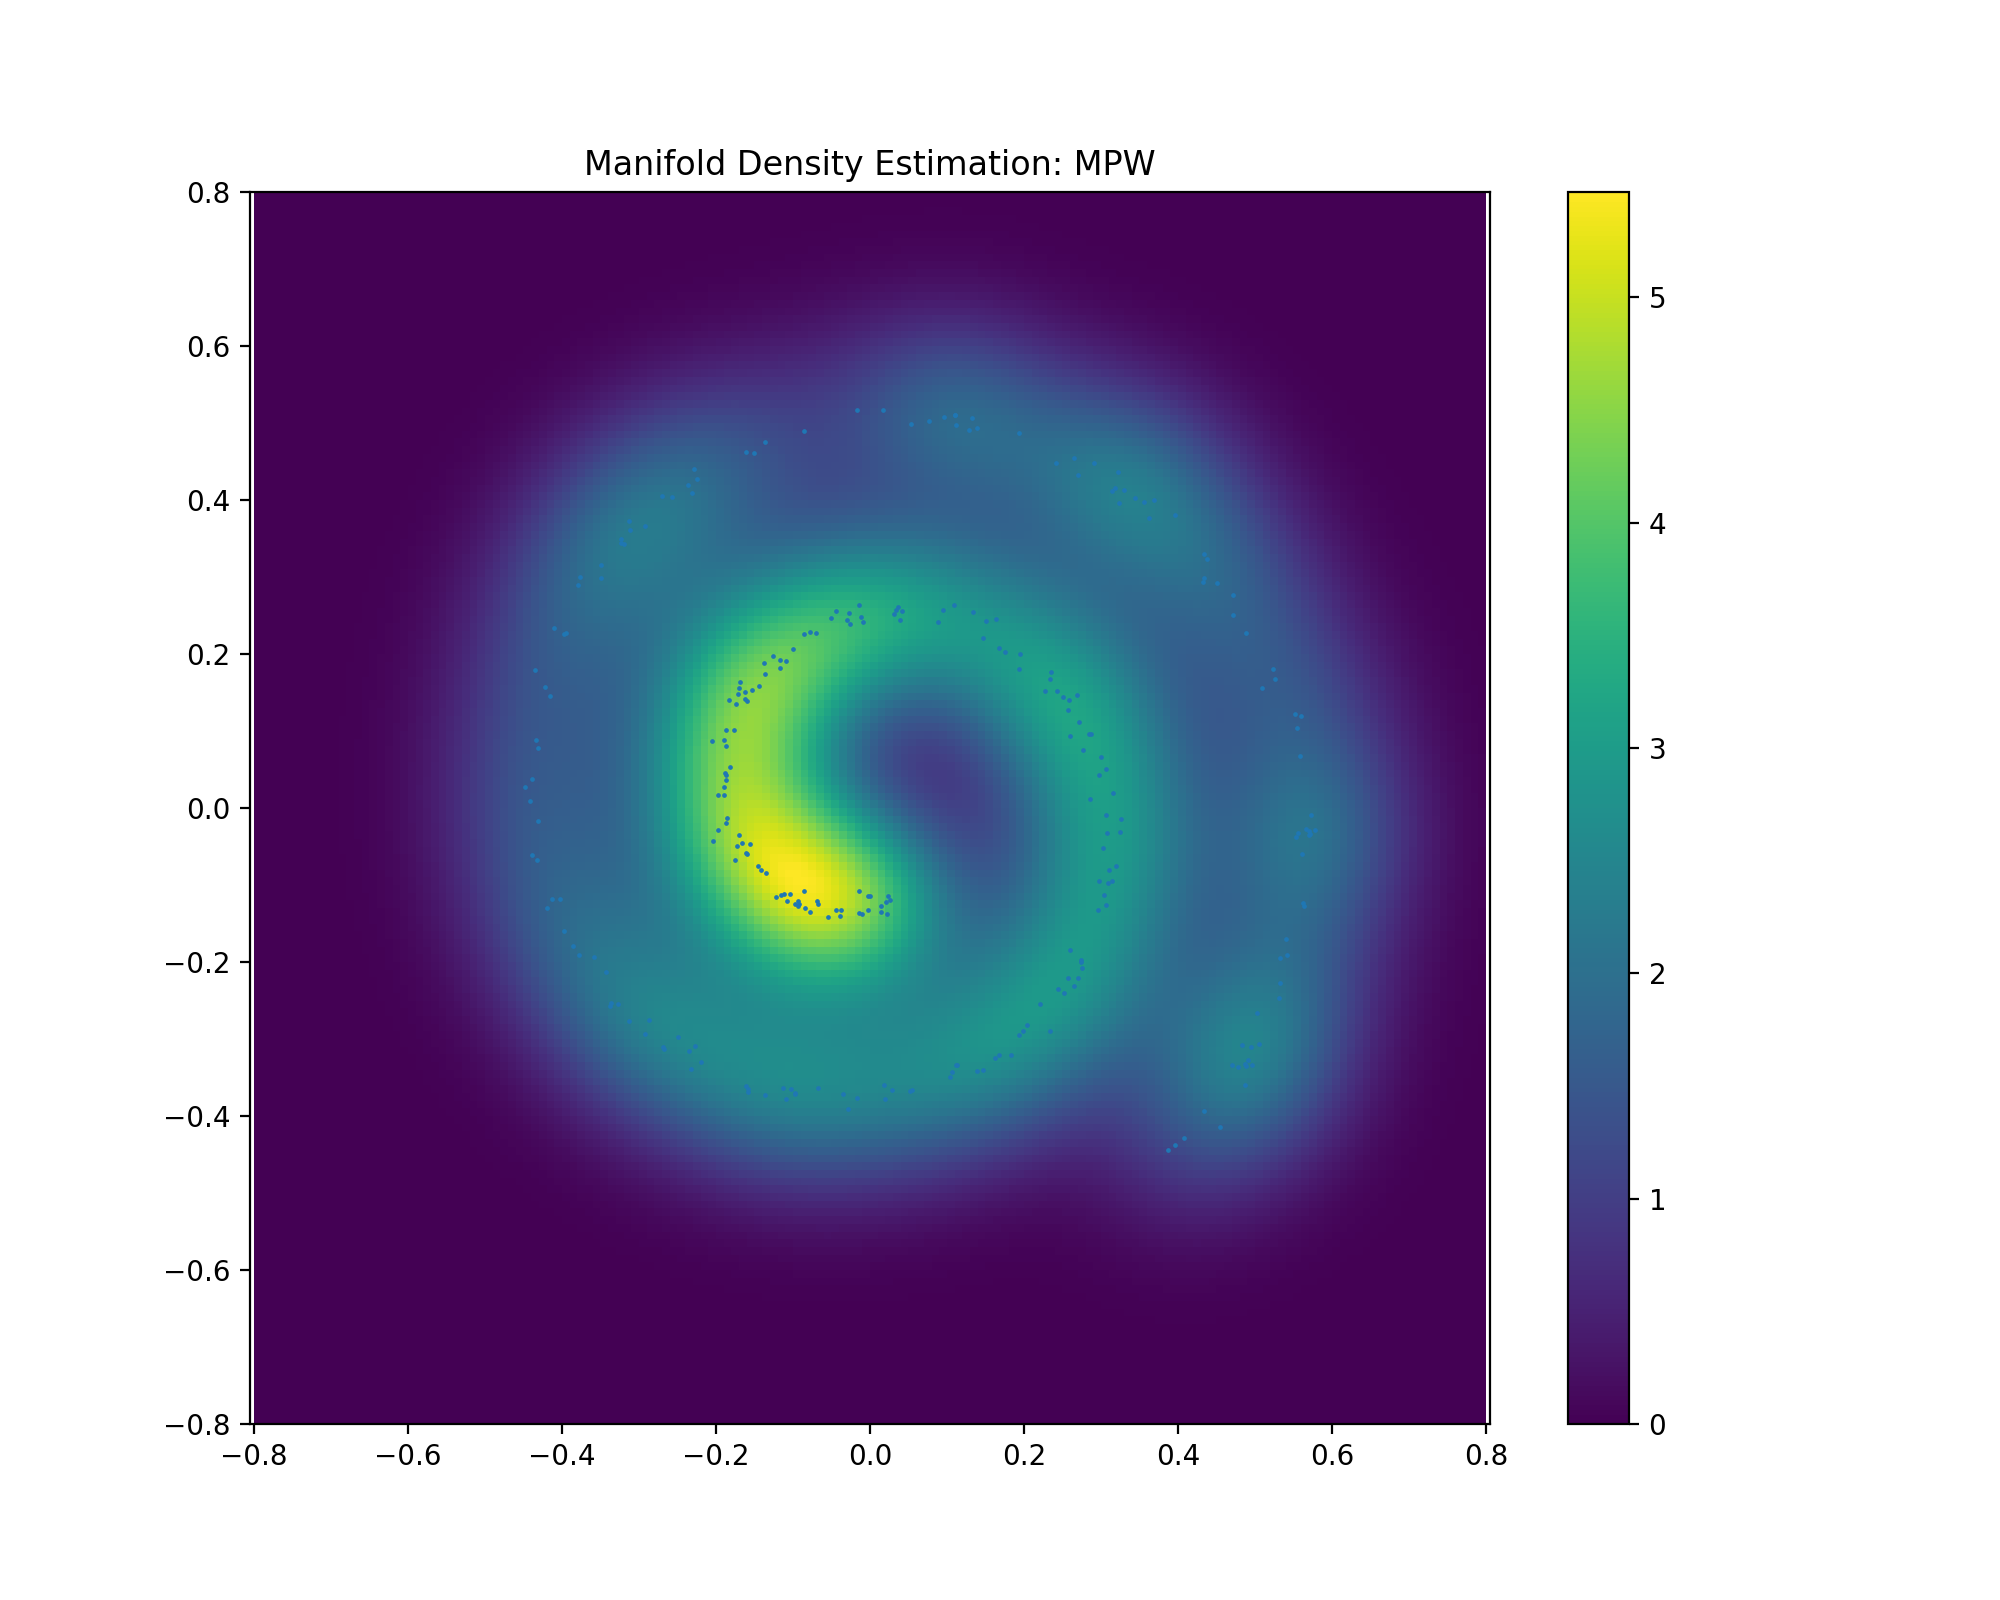

In [12]:
plot_2d_density(X, likelihoods_image, extent, "MPW")

### Evaluate ANLL on test set drawn from the same distribution

In [13]:
likelihoods = np.zeros((X_te.shape[0], 1))
for i in range(X_te.shape[0]):
    likelihoods[i] = ManifoldParzenTest(X_te[i], model)

In [14]:
print(ANLL(likelihoods)) # no idea why this doesn't agree with the paper's reported result

-0.99767298131


<IPython.core.display.Javascript object>


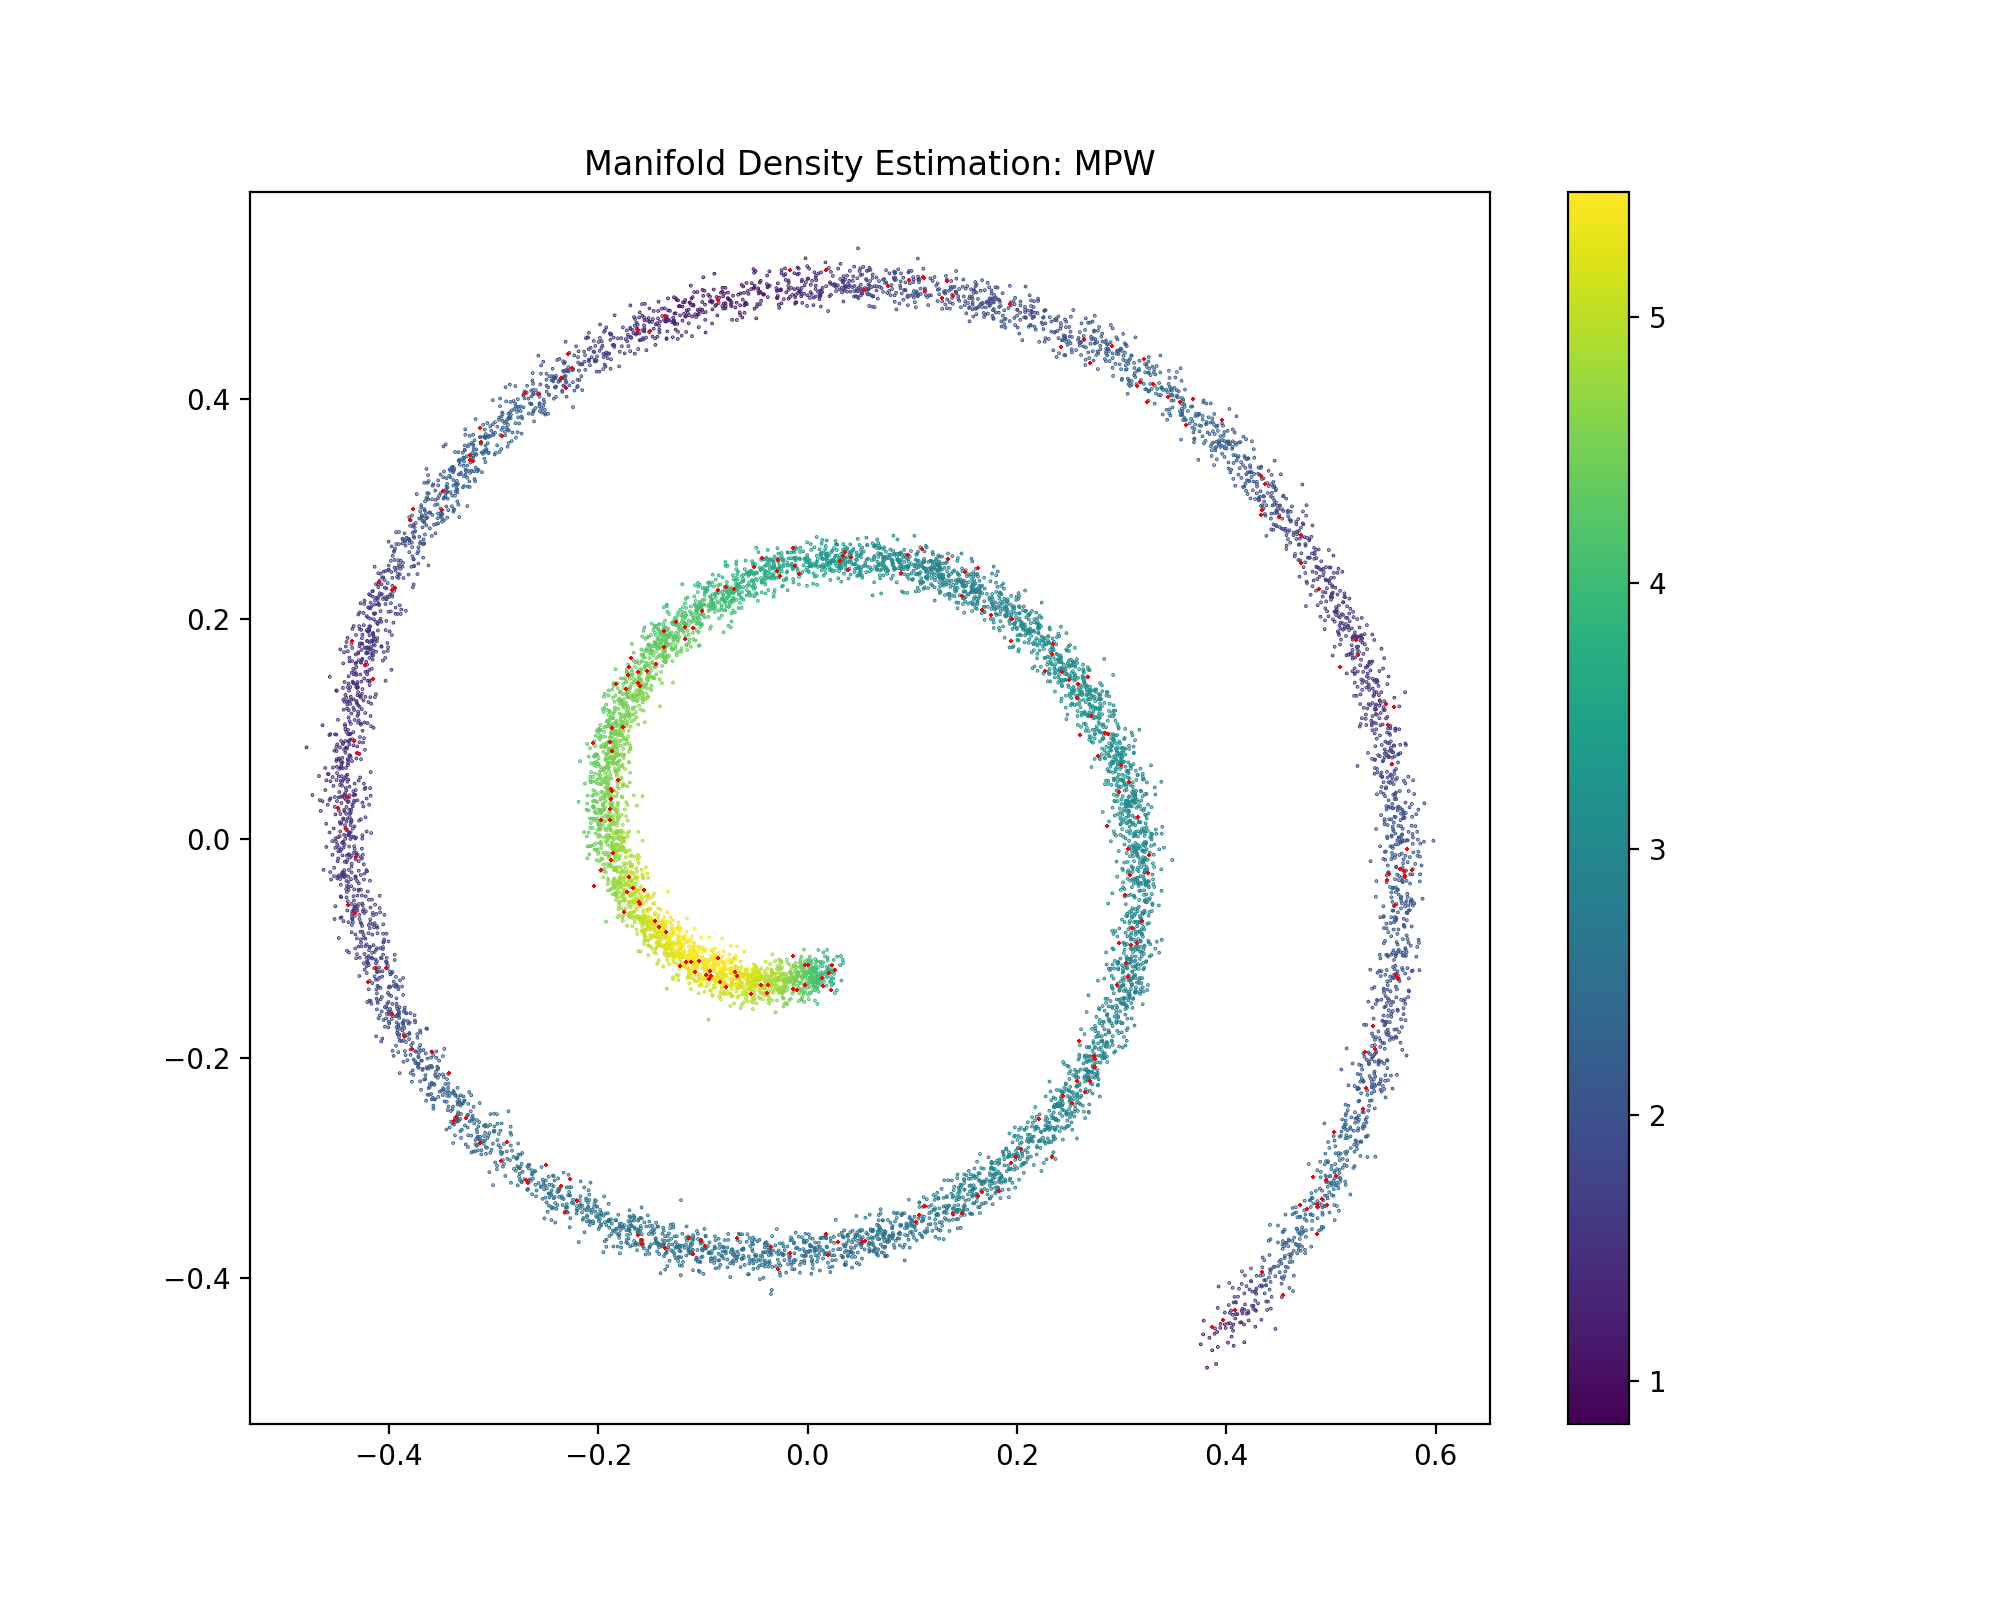

In [15]:
plt.figure(figsize=(10, 8))
plt.title("Manifold Density Estimation: MPW")

plt.scatter(X_te[:, 0], X_te[:, 1], cmap=plt.cm.viridis, c=likelihoods, marker='.', s=0.5)
plt.colorbar()

plt.scatter(X[:, 0], X[:, 1], marker='+', c='red', s=0.5)

plt.show()